# Importing the libraries

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

C:\Users\Divyojyoti Sinha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import sys 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import os
import sys
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "C:\\Data_Science\\Data_science\\CAPP\\"
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Reading the Image Data

In [5]:
DIR = "C:\\Data_Science\\Data_science\\CAPP\\data\\dogscats\\dogscats\\valid\\"
sz=224

In [4]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['cats']:
                label = 0
            elif nextDir in ['dogs']:
                label = 1

                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file, 0)
                if img is not None:
                    #img = np.frombuffer(img, dtype=np.uint8).astype(np.float32)
                    img = skimage.transform.resize(img, (64, 64), mode='constant')
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    #img = img.reshape(-1)
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
df_X, df_Y = get_data(DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.38it/s]


In [7]:
print(df_X.shape,'\n',df_Y.shape)

(2000, 64, 64) 
 (2000,)


# Train - Test Split

In [8]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(df_X,
                                                             df_Y,
                                                             test_size=0.2,
                                                             random_state=13)

In [9]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (1600, 64, 64)
Test set (images) shape: (400, 64, 64)


In [10]:
# Create dictionary of target classes
label_dict = {
 0: 'C',
 1: 'D'
}

Text(0.5,1,'(Label: D)')

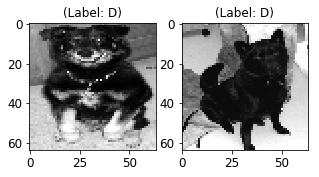

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (64,64))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (64,64))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Data Preprocessing

The images of the dataset are grayscale images with pixel values ranging from 0 to 255 with a dimension of 64 x 64, so before it is fed into the model, it is very important to preprocess it. We first need to convert each 64 x 64 image of train and test set into a matrix of size 64 x 64 x 1, which can be fed into the network:

In [12]:
train_data = train_data.reshape(-1, 64,64, 1)
test_data = test_data.reshape(-1, 64,64, 1)
train_data.shape, test_data.shape

((1600, 64, 64, 1), (400, 64, 64, 1))

Now, we need to make sure to check the data type of the training and testing NumPy arrays, it should be in float32 format, if not we will need to convert it into this format. 

In [13]:
train_data.dtype, test_data.dtype

(dtype('float64'), dtype('float64'))

In [14]:
train_data = train_data.astype(np.float32)
train_data.dtype

dtype('float32')

In [15]:
test_data = test_data.astype(np.float32)
test_data.dtype

dtype('float32')

We also need to make sure that the pixel values have been rescaled in range 0 - 1 inclusive.

In [16]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

## Partitioning the data into train - validation sets

It's important to partition the data. In order for our model to generalize well, we need to split the training data into two parts: a training and a validation set. We will need to train our model on 80% of the data and validate it on 20% of the remaining training data.

This will also help us in reducing the chances of overfitting, as we will be validating our model on data it would not have seen in the training phase.

The train_test_split module of scikit-learn can be used to divide the data properly:

In [17]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

# Building Convolutional Autoencoder

The images are of size 64 x 64 x 1 or a 4096-dimensional vector. We need to convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 64 x 64 x 1, and feed this as an input to the network.

Also, we are using a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system. It contributes heavily in determining the learning parameters and affects the prediction accuracy.

In [41]:
batch_size = 128
epochs = 200
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

In [42]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [43]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [44]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_45 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_46 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [45]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,
                                    epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 1280 samples, validate on 320 samples
Epoch 1/200
1280/1280 [==============================] - ETA: 35s - loss: 0.13 - ETA: 17s - loss: 0.11 - ETA: 10s - loss: 0.10 - ETA: 7s - loss: 0.1093 - ETA: 5s - loss: 0.106 - ETA: 3s - loss: 0.099 - ETA: 2s - loss: 0.093 - ETA: 1s - loss: 0.087 - ETA: 0s - loss: 0.083 - 7s 6ms/step - loss: 0.0796 - val_loss: 0.1202
Epoch 2/200
1280/1280 [==============================] - ETA: 2s - loss: 0.036 - ETA: 2s - loss: 0.032 - ETA: 2s - loss: 0.031 - ETA: 1s - loss: 0.030 - ETA: 1s - loss: 0.030 - ETA: 1s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - 3s 2ms/step - loss: 0.0294 - val_loss: 0.0449
Epoch 3/200
1280/1280 [==============================] - ETA: 2s - loss: 0.031 - ETA: 2s - loss: 0.030 - ETA: 2s - loss: 0.029 - ETA: 1s - loss: 0.028 - ETA: 1s - loss: 0.027 - ETA: 1s - loss: 0.026 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.026 - 3s 2ms/step - loss: 0.0264 - val_loss: 0.

1280/1280 [==============================] - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 3s 3ms/step - loss: 0.0101 - val_loss: 0.0385
Epoch 27/200
1280/1280 [==============================] - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - 3s 3ms/step - loss: 0.0095 - val_loss: 0.0315
Epoch 28/200
1280/1280 [==============================] - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - 3s 3ms/step - loss: 0.0093 - val_loss: 0.0303
Epoch 29/200
1280/1280 [=============================

1280/1280 [==============================] - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 3s 3ms/step - loss: 0.0072 - val_loss: 0.0145
Epoch 52/200
1280/1280 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 3s 3ms/step - loss: 0.0073 - val_loss: 0.0182
Epoch 53/200
1280/1280 [==============================] - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 3ms/step - loss: 0.0069 - val_loss: 0.0152
Epoch 54/200
1280/1280 [=============================

1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.006 - 3s 3ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 77/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 3ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 78/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 79/200
1280/1280 [=============================

1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0055 - val_loss: 0.0074
Epoch 102/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 103/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0057 - val_loss: 0.0080
Epoch 104/200
1280/1280 [==========================

1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 127/200
1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 128/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 3s 3ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 129/200
1280/1280 [==========================

1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 3ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 152/200
1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 3ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 153/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 3ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 154/200
1280/1280 [==========================

1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 3ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 177/200
1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 3ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 178/200
1280/1280 [==============================] - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 3s 3ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 179/200
1280/1280 [==========================

In [47]:
autoencoder.save('autoencoder_64_16_200.h5')

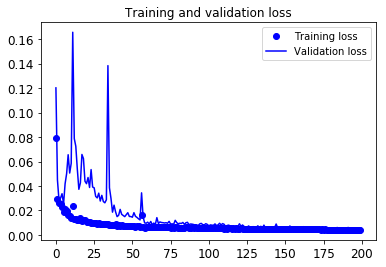

In [46]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [48]:
restored_imgs  = autoencoder.predict(test_data)

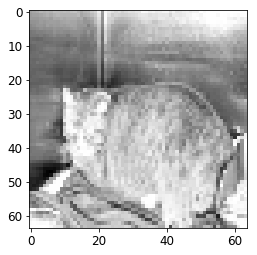

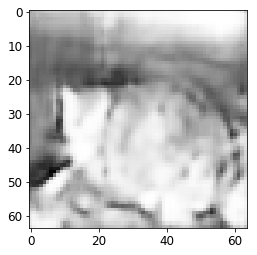

----------------------------


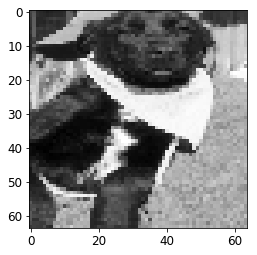

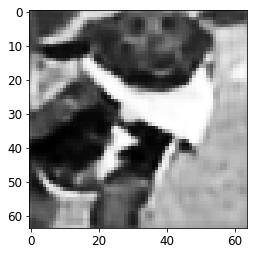

----------------------------


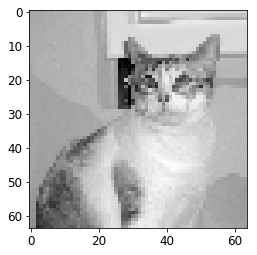

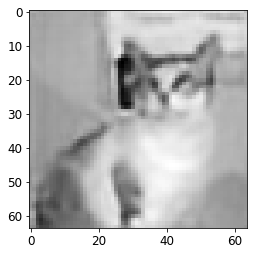

----------------------------


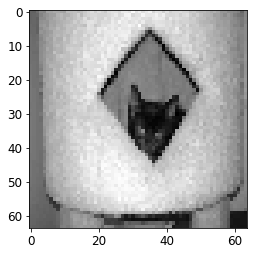

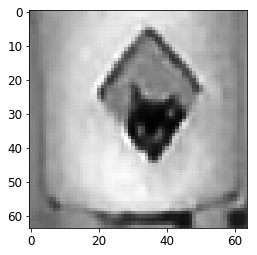

----------------------------


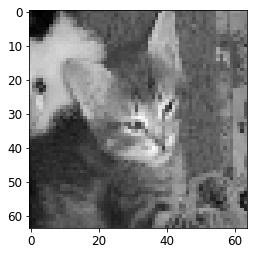

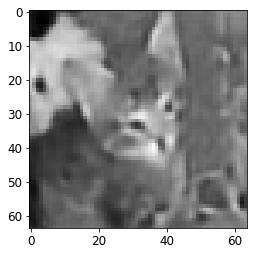

----------------------------


In [49]:
for i in range(5):
    plt.imshow(test_data[i].reshape(64, 64))
    plt.gray()
    plt.show()
    
    plt.imshow(restored_imgs[i].reshape(64, 64))
    plt.gray()
    plt.show()
    
    print("----------------------------")

In [50]:
layers = len(autoencoder.layers)

for i in range(layers):
    print(i, ". ", autoencoder.layers[i].output.get_shape())

0 .  (?, 64, 64, 1)
1 .  (?, 64, 64, 32)
2 .  (?, 64, 64, 32)
3 .  (?, 64, 64, 32)
4 .  (?, 64, 64, 32)
5 .  (?, 32, 32, 32)
6 .  (?, 32, 32, 64)
7 .  (?, 32, 32, 64)
8 .  (?, 32, 32, 64)
9 .  (?, 32, 32, 64)
10 .  (?, 16, 16, 64)
11 .  (?, 16, 16, 128)
12 .  (?, 16, 16, 128)
13 .  (?, 16, 16, 128)
14 .  (?, 16, 16, 128)
15 .  (?, 16, 16, 256)
16 .  (?, 16, 16, 256)
17 .  (?, 16, 16, 256)
18 .  (?, 16, 16, 256)
19 .  (?, 16, 16, 128)
20 .  (?, 16, 16, 128)
21 .  (?, 16, 16, 128)
22 .  (?, 16, 16, 128)
23 .  (?, 16, 16, 64)
24 .  (?, 16, 16, 64)
25 .  (?, 16, 16, 64)
26 .  (?, 16, 16, 64)
27 .  (?, 32, 32, 64)
28 .  (?, 32, 32, 32)
29 .  (?, 32, 32, 32)
30 .  (?, 32, 32, 32)
31 .  (?, 32, 32, 32)
32 .  (?, 64, 64, 32)
33 .  (?, 64, 64, 1)


In [51]:
#layer[26] is compressed representation
get_3rd_layer_output = K.function([autoencoder.layers[0].input], [autoencoder.layers[26].output])
compressed = get_3rd_layer_output([test_data])[0]

In [52]:
compressed.shape

(400, 16, 16, 64)

In [54]:
#layer[26] is size of (None, 16, 16, 64). this means 64 different 16 x 16 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(400,16*16*64)

In [55]:
from tensorflow.contrib.factorization.python.ops import clustering_ops
import tensorflow as tf

In [65]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
    2 #num of clusters
    , distance_metric = clustering_ops.COSINE_DISTANCE
    , initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016C458DE828>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\DIVYOJ~1\\AppData\\Local\\Temp\\tmpvyr1h77w'}


In [66]:
def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [67]:
unsupervised_model.fit(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\DIVYOJ~1\AppData\Local\Temp\tmpvyr1h77w\model.ckpt.
INFO:tensorflow:loss = 359.52142, step = 1
INFO:tensorflow:global_step/sec: 13.231
INFO:tensorflow:loss = 287.1713, step = 101 (7.559 sec)
INFO:tensorflow:global_step/sec: 38.7733
INFO:tensorflow:loss = 287.12543, step = 201 (2.579 sec)
INFO:tensorflow:global_step/sec: 38.7882
INFO:tensorflow:loss = 287.09647, step = 301 (2.578 sec)
INFO:tensorflow:global_step/sec: 39.1823
INFO:tensorflow:loss = 287.08618, step = 401 (2.552 sec)
INFO:tensorflow:global_step/sec: 39.0297
INFO:tensorflow:loss = 287.08142, step = 501 (2.562 sec)
INFO:tensorflow:global_step/sec: 38.6685
INFO:tensorflow:loss = 287.0788, step = 601 (2.586 sec)
INFO:tensorflow:global_step/sec: 37.8367
INFO:tensorflow:loss = 287.0772, step = 701 (2.643 sec)
INFO

KMeansClustering(params={'num_clusters': 2, 'training_initial_clusters': 'random', 'distance_metric': 'cosine', 'random_seed': 0, 'use_mini_batch': True, 'mini_batch_steps_per_iteration': 1, 'kmeans_plus_plus_num_retries': 2, 'relative_tolerance': None})

In [68]:
clusters = unsupervised_model.predict(input_fn=train_input_fn)



INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DIVYOJ~1\AppData\Local\Temp\tmpvyr1h77w\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [69]:
index = 0
c_0_count = 0
c_1_count = 0

mis_classified = 0
corr_classified = 0


for i in clusters:
    
    current_cluster = i['cluster_idx']
    features = test_data[index]
    
    
    if current_cluster == 0:
            if test_labels[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_0_count += 1
            
    if current_cluster == 1:
            if test_labels[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_1_count += 1
            
            

            
    index = index + 1

## Accuracy using tensorflow-clustering

In [70]:
accuracy = corr_classified/len(test_labels)
accuracy

0.5425

### using simple kmeans

In [88]:
from sklearn.cluster import KMeans


In [89]:
k = KMeans(n_clusters=2, n_jobs=-1, random_state=728)
# Let's do some timings to see how long it takes to train.
# Train it up
k.fit(compressed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=728, tol=0.0001, verbose=0)

In [76]:
cluster_df = pd.DataFrame({'Clusters' : list(k.labels_), 'test_labels' : list(test_labels)})
cluster_df.head()

,Clusters,test_labels
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0


In [77]:
def label(val):
    k=val[0]
    m=val[1]
    if k==m:
        return 1
    else:
        return 0

In [78]:
cluster_df['Newlabel']=cluster_df[['Clusters','test_labels']].apply(label,axis=1)

In [79]:
cluster_df.head()

,Clusters,test_labels,Newlabel
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [93]:
accuracy_kmeans = cluster_df['Newlabel'].sum()/test_labels.shape[0]
accuracy_kmeans

0.505

# Try 2 

- using adadelta optimizer

In [95]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np

In [97]:
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
    , padding='same', input_shape=(64,64,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------

model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 2)         290       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 2)         0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 16, 2)         38        
__________

In [99]:

model.compile(optimizer='adadelta', loss='binary_crossentropy')

model.fit(train_X, train_X
    , epochs=50
    , validation_data=(valid_X, valid_X)
)

Train on 1280 samples, validate on 320 samples
Epoch 1/50
1280/1280 [==============================] - ETA: 2:01 - loss: 0.693 - ETA: 28s - loss: 0.693 - ETA: 15s - loss: 0.69 - ETA: 8s - loss: 0.6922 - ETA: 5s - loss: 0.690 - ETA: 3s - loss: 0.689 - ETA: 2s - loss: 0.688 - ETA: 1s - loss: 0.685 - ETA: 1s - loss: 0.683 - ETA: 0s - loss: 0.679 - ETA: 0s - loss: 0.676 - 4s 3ms/step - loss: 0.6752 - val_loss: 0.6343
Epoch 2/50
1280/1280 [==============================] - ETA: 0s - loss: 0.643 - ETA: 0s - loss: 0.645 - ETA: 0s - loss: 0.634 - ETA: 0s - loss: 0.646 - ETA: 0s - loss: 0.639 - ETA: 0s - loss: 0.633 - ETA: 0s - loss: 0.635 - ETA: 0s - loss: 0.633 - ETA: 0s - loss: 0.630 - ETA: 0s - loss: 0.629 - 1s 476us/step - loss: 0.6288 - val_loss: 0.6059
Epoch 3/50
1280/1280 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.610 - ETA: 0s - loss: 0.616 - ETA: 0s - loss: 0.614 - ETA: 0s - loss: 0.613 - ETA: 0s - loss: 0.612 - ETA: 0s - loss: 0.612 - ETA: 0s - loss:

1280/1280 [==============================] - ETA: 0s - loss: 0.583 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.577 - 1s 500us/step - loss: 0.5778 - val_loss: 0.5797
Epoch 25/50
1280/1280 [==============================] - ETA: 0s - loss: 0.567 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.580 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.576 - 1s 510us/step - loss: 0.5774 - val_loss: 0.5773
Epoch 26/50
1280/1280 [==============================] - ETA: 0s - loss: 0.592 - ETA: 0s - loss: 0.581 - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.577 - E

1280/1280 [==============================] - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.567 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.568 - ETA: 0s - loss: 0.569 - ETA: 0s - loss: 0.569 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.571 - ETA: 0s - loss: 0.572 - ETA: 0s - loss: 0.573 - 1s 487us/step - loss: 0.5733 - val_loss: 0.5743
Epoch 48/50
1280/1280 [==============================] - ETA: 0s - loss: 0.587 - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.573 - 1s 457us/step - loss: 0.5729 - val_loss: 0.5730
Epoch 49/50
1280/1280 [==============================] - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.572 - ETA: 0s - loss: 0.572 - ETA: 0s - loss: 0.572 - ETA: 0s - loss: 0.572 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.574 - 1s 484us/step - loss: 0.5

In [101]:
restored_imgs = model.predict(valid_X)

In [102]:
layers = len(model.layers)

for i in range(layers):
    print(i, ". ", model.layers[i].output.get_shape())

0 .  (?, 64, 64, 16)
1 .  (?, 64, 64, 16)
2 .  (?, 32, 32, 16)
3 .  (?, 32, 32, 2)
4 .  (?, 32, 32, 2)
5 .  (?, 16, 16, 2)
6 .  (?, 16, 16, 2)
7 .  (?, 16, 16, 2)
8 .  (?, 32, 32, 2)
9 .  (?, 32, 32, 16)
10 .  (?, 32, 32, 16)
11 .  (?, 64, 64, 16)
12 .  (?, 64, 64, 1)
13 .  (?, 64, 64, 1)


In [103]:
#layer[7] is activation_3 (Activation), it is compressed representation
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[7].output])
compressed = get_3rd_layer_output([valid_X])[0]

In [106]:

#layer[7] is size of (None, 16, 16, 2). this means 2 different 7x7 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(320,16*16*2)

In [108]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
    2 #num of clusters
    , distance_metric = clustering_ops.COSINE_DISTANCE
    , initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016C46517B38>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\DIVYOJ~1\\AppData\\Local\\Temp\\tmp6l24yayy'}


In [109]:
def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [110]:
unsupervised_model.fit(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\DIVYOJ~1\AppData\Local\Temp\tmp6l24yayy\model.ckpt.
INFO:tensorflow:loss = 90.86919, step = 1
INFO:tensorflow:global_step/sec: 426.471
INFO:tensorflow:loss = 53.918396, step = 101 (0.234 sec)
INFO:tensorflow:global_step/sec: 731.885
INFO:tensorflow:loss = 53.74006, step = 201 (0.137 sec)
INFO:tensorflow:global_step/sec: 765.402
INFO:tensorflow:loss = 53.685707, step = 301 (0.131 sec)
INFO:tensorflow:global_step/sec: 706.106
INFO:tensorflow:loss = 53.661842, step = 401 (0.142 sec)
INFO:tensorflow:global_step/sec: 711.118
INFO:tensorflow:loss = 53.648743, step = 501 (0.141 sec)
INFO:tensorflow:global_step/sec: 795.771
INFO:tensorflow:loss = 53.641083, step = 601 (0.126 sec)
INFO:tensorflow:global_step/sec: 765.397
INFO:tensorflow:loss = 53.634193, step = 701 (0.131 sec)
IN

KMeansClustering(params={'num_clusters': 2, 'training_initial_clusters': 'random', 'distance_metric': 'cosine', 'random_seed': 0, 'use_mini_batch': True, 'mini_batch_steps_per_iteration': 1, 'kmeans_plus_plus_num_retries': 2, 'relative_tolerance': None})

In [111]:
clusters = unsupervised_model.predict(input_fn=train_input_fn)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DIVYOJ~1\AppData\Local\Temp\tmp6l24yayy\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [112]:
index = 0
c_0_count = 0
c_1_count = 0

mis_classified = 0
corr_classified = 0


for i in clusters:
    
    current_cluster = i['cluster_idx']
    features = test_data[index]
    
    
    if current_cluster == 0:
            if test_labels[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_0_count += 1
            
    if current_cluster == 1:
            if test_labels[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_1_count += 1
            
            

            
    index = index + 1

In [113]:
accuracy = corr_classified/len(valid_ground)
accuracy

0.546875

## Try 3

In [95]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np

In [118]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    #input = 64 x 64 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #64 x 64 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #32 x 32 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #32 x 32 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #16 x 16 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #16 x 16 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #8 x 8 x 128
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #8 x 8 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4



def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #8 x 8 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2,2))(conv5) #16 x 16 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) #16 x 16 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6) #32 x 32 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) # 32 x 32 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 64 x 64 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 64 x 64 x 1
    return decoded

In [119]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [120]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_73 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [121]:
autoencoder_train = autoencoder.fit(train_X, train_X, batch_size=batch_size,
                                    epochs=200,verbose=1,validation_data=(valid_X, valid_X))

Train on 1280 samples, validate on 320 samples
Epoch 1/200
1280/1280 [==============================] - ETA: 27s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 8s - loss: 0.1084 - ETA: 5s - loss: 0.104 - ETA: 3s - loss: 0.101 - ETA: 2s - loss: 0.097 - ETA: 1s - loss: 0.089 - ETA: 1s - loss: 0.084 - ETA: 0s - loss: 0.078 - 6s 4ms/step - loss: 0.0742 - val_loss: 0.0751
Epoch 2/200
1280/1280 [==============================] - ETA: 2s - loss: 0.033 - ETA: 1s - loss: 0.031 - ETA: 1s - loss: 0.031 - ETA: 1s - loss: 0.031 - ETA: 1s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - 3s 2ms/step - loss: 0.0311 - val_loss: 0.0401
Epoch 3/200
1280/1280 [==============================] - ETA: 2s - loss: 0.028 - ETA: 1s - loss: 0.029 - ETA: 1s - loss: 0.031 - ETA: 1s - loss: 0.033 - ETA: 1s - loss: 0.033 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - 3s 2ms/step - loss: 0.0303 - val_loss: 0.

1280/1280 [==============================] - ETA: 2s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - 3s 2ms/step - loss: 0.0129 - val_loss: 0.0344
Epoch 27/200
1280/1280 [==============================] - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.013 - ETA: 1s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - 3s 2ms/step - loss: 0.0130 - val_loss: 0.0396
Epoch 28/200
1280/1280 [==============================] - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - 3s 2ms/step - loss: 0.0128 - val_loss: 0.0299
Epoch 29/200
1280/1280 [=============================

1280/1280 [==============================] - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 3s 2ms/step - loss: 0.0101 - val_loss: 0.0153
Epoch 52/200
1280/1280 [==============================] - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - 3s 2ms/step - loss: 0.0100 - val_loss: 0.0173
Epoch 53/200
1280/1280 [==============================] - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - 3s 2ms/step - loss: 0.0095 - val_loss: 0.0153
Epoch 54/200
1280/1280 [=============================

1280/1280 [==============================] - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 3s 2ms/step - loss: 0.0087 - val_loss: 0.0123
Epoch 77/200
1280/1280 [==============================] - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 3s 2ms/step - loss: 0.0085 - val_loss: 0.0126
Epoch 78/200
1280/1280 [==============================] - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 3s 2ms/step - loss: 0.0084 - val_loss: 0.0112
Epoch 79/200
1280/1280 [=============================

1280/1280 [==============================] - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 3s 2ms/step - loss: 0.0077 - val_loss: 0.0111
Epoch 102/200
1280/1280 [==============================] - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 3s 2ms/step - loss: 0.0078 - val_loss: 0.0112
Epoch 103/200
1280/1280 [==============================] - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 3s 2ms/step - loss: 0.0077 - val_loss: 0.0119
Epoch 104/200
1280/1280 [==========================

1280/1280 [==============================] - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - 3s 2ms/step - loss: 0.0071 - val_loss: 0.0097
Epoch 127/200
1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 3s 2ms/step - loss: 0.0071 - val_loss: 0.0100
Epoch 128/200
1280/1280 [==============================] - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 129/200
1280/1280 [==========================

1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 152/200
1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 153/200
1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0066 - val_loss: 0.0101
Epoch 154/200
1280/1280 [==========================

1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0062 - val_loss: 0.0100
Epoch 177/200
1280/1280 [==============================] - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0061 - val_loss: 0.0100
Epoch 178/200
1280/1280 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 3s 2ms/step - loss: 0.0064 - val_loss: 0.0093
Epoch 179/200
1280/1280 [==========================

In [126]:
autoencoder.save('autoencoder_64_8_200.h5')

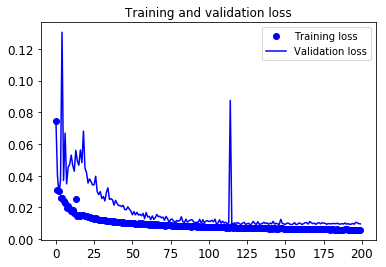

In [122]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [127]:
restored_imgs  = autoencoder.predict(valid_X)

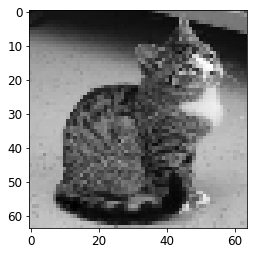

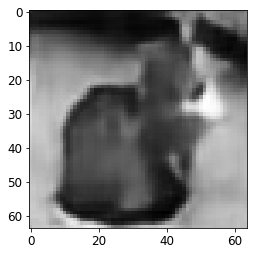

----------------------------


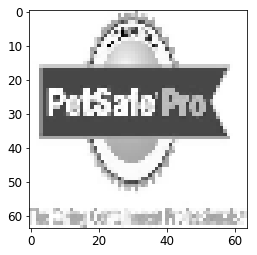

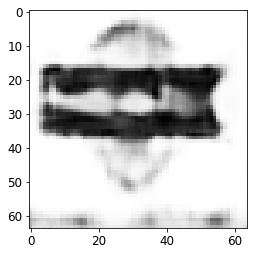

----------------------------


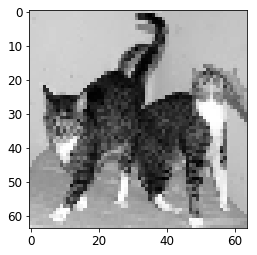

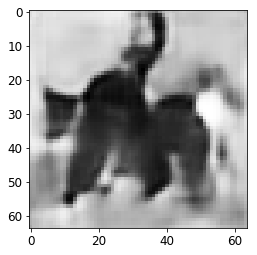

----------------------------


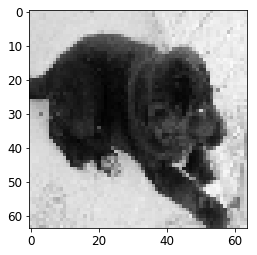

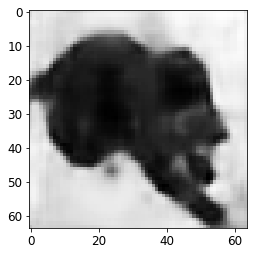

----------------------------


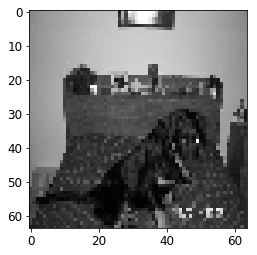

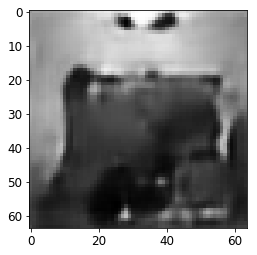

----------------------------


In [129]:
for i in range(5):
    plt.imshow(valid_X[i].reshape(64, 64))
    plt.gray()
    plt.show()
    
    plt.imshow(restored_imgs[i].reshape(64, 64))
    plt.gray()
    plt.show()
    
    print("----------------------------")

In [130]:
layers = len(autoencoder.layers)

for i in range(layers):
    print(i, ". ", autoencoder.layers[i].output.get_shape())

0 .  (?, 64, 64, 1)
1 .  (?, 64, 64, 32)
2 .  (?, 64, 64, 32)
3 .  (?, 64, 64, 32)
4 .  (?, 64, 64, 32)
5 .  (?, 32, 32, 32)
6 .  (?, 32, 32, 64)
7 .  (?, 32, 32, 64)
8 .  (?, 32, 32, 64)
9 .  (?, 32, 32, 64)
10 .  (?, 16, 16, 64)
11 .  (?, 16, 16, 128)
12 .  (?, 16, 16, 128)
13 .  (?, 16, 16, 128)
14 .  (?, 16, 16, 128)
15 .  (?, 8, 8, 128)
16 .  (?, 8, 8, 256)
17 .  (?, 8, 8, 256)
18 .  (?, 8, 8, 256)
19 .  (?, 8, 8, 256)
20 .  (?, 8, 8, 128)
21 .  (?, 8, 8, 128)
22 .  (?, 8, 8, 128)
23 .  (?, 8, 8, 128)
24 .  (?, 16, 16, 128)
25 .  (?, 16, 16, 64)
26 .  (?, 16, 16, 64)
27 .  (?, 16, 16, 64)
28 .  (?, 16, 16, 64)
29 .  (?, 32, 32, 64)
30 .  (?, 32, 32, 32)
31 .  (?, 32, 32, 32)
32 .  (?, 32, 32, 32)
33 .  (?, 32, 32, 32)
34 .  (?, 64, 64, 32)
35 .  (?, 64, 64, 1)


In [131]:
#layer[7] is activation_3 (Activation), it is compressed representation
get_3rd_layer_output = K.function([autoencoder.layers[0].input], [autoencoder.layers[23].output])
compressed = get_3rd_layer_output([valid_X])[0]

In [132]:

#layer[7] is size of (None, 16, 16, 2). this means 2 different 7x7 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(320,8*8*128)

In [133]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
    2 #num of clusters
    , distance_metric = clustering_ops.COSINE_DISTANCE
    , initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016C468AFA58>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\DIVYOJ~1\\AppData\\Local\\Temp\\tmp3xoe8peo'}


In [134]:
def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [135]:
unsupervised_model.fit(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\DIVYOJ~1\AppData\Local\Temp\tmp3xoe8peo\model.ckpt.
INFO:tensorflow:loss = 300.71945, step = 1
INFO:tensorflow:global_step/sec: 41.3328
INFO:tensorflow:loss = 242.63353, step = 101 (2.419 sec)
INFO:tensorflow:global_step/sec: 323.443
INFO:tensorflow:loss = 242.56328, step = 201 (0.309 sec)
INFO:tensorflow:global_step/sec: 348.151
INFO:tensorflow:loss = 242.54504, step = 301 (0.287 sec)
INFO:tensorflow:global_step/sec: 348.151
INFO:tensorflow:loss = 242.53055, step = 401 (0.287 sec)
INFO:tensorflow:global_step/sec: 345.749
INFO:tensorflow:loss = 242.51672, step = 501 (0.288 sec)
INFO:tensorflow:global_step/sec: 325.542
INFO:tensorflow:loss = 242.50687, step = 601 (0.308 sec)
INFO:tensorflow:global_step/sec: 290.631
INFO:tensorflow:loss = 242.50092, step = 701 (0.344 sec)


KMeansClustering(params={'num_clusters': 2, 'training_initial_clusters': 'random', 'distance_metric': 'cosine', 'random_seed': 0, 'use_mini_batch': True, 'mini_batch_steps_per_iteration': 1, 'kmeans_plus_plus_num_retries': 2, 'relative_tolerance': None})

In [136]:
clusters = unsupervised_model.predict(input_fn=train_input_fn)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DIVYOJ~1\AppData\Local\Temp\tmp3xoe8peo\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [137]:
index = 0
c_0_count = 0
c_1_count = 0

mis_classified = 0
corr_classified = 0


for i in clusters:
    
    current_cluster = i['cluster_idx']
    features = test_data[index]
    
    
    if current_cluster == 0:
            if test_labels[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_0_count += 1
            
    if current_cluster == 1:
            if test_labels[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_1_count += 1
            
            

            
    index = index + 1

In [138]:
accuracy = corr_classified/len(valid_ground)
accuracy

0.496875